In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import sys

import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = "/content/drive/MyDrive/OMSCS/DL/FinalProject"
sys.path.append(os.path.abspath(DIR))

from team36.mnist.vgg import VGG
from team36.training import train, validate
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet

NAME = "cifar10"
DATA_SET_CLASS = torchvision.datasets.CIFAR10
image_size = 32
in_channels = 3
fgsm_alpha = 0.5
fgsm_epsilon = 0.007

In [7]:
DATA_DIR = f'{DIR}/data'

training_set = DATA_SET_CLASS(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())

prev_model = VGG(image_size=image_size, in_channels=in_channels)
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
prev_model.load_state_dict(state_dict)
prev_criterion = nn.CrossEntropyLoss()

attack_training_set = FastSignGradientAttackDataSet(training_set, prev_model, prev_criterion, epsilon=fgsm_epsilon)
indices = torch.randperm(len(attack_training_set))[:int(len(attack_training_set) * 0.1)]
attack_training_set = torch.utils.data.Subset(attack_training_set, indices)

combined_training_set = torch.utils.data.ConcatDataset([training_set, attack_training_set])

training_indices, validation_indices = train_test_split(
    range(len(combined_training_set)),
    test_size=0.1,
)
training_split = torch.utils.data.Subset(combined_training_set, training_indices)
validation_split = torch.utils.data.Subset(combined_training_set, validation_indices)

print(f"{len(training_split)} in training set")
print(f"{len(validation_split)} in validation set")

Files already downloaded and verified
49500 in training set
5500 in validation set


Epoch: [0][0/774]	Loss 2.4422 (2.4422)	Prec @1 0.1406 (0.1406)	
Epoch: [0][10/774]	Loss 2.2075 (2.3539)	Prec @1 0.2344 (0.1634)	
Epoch: [0][20/774]	Loss 1.9628 (2.3039)	Prec @1 0.3281 (0.2202)	
Epoch: [0][30/774]	Loss 2.6351 (2.2850)	Prec @1 0.2344 (0.2510)	
Epoch: [0][40/774]	Loss 2.6687 (2.3246)	Prec @1 0.2500 (0.2698)	
Epoch: [0][50/774]	Loss 2.5534 (2.2909)	Prec @1 0.3750 (0.2907)	
Epoch: [0][60/774]	Loss 1.6572 (2.2554)	Prec @1 0.4062 (0.3033)	
Epoch: [0][70/774]	Loss 2.1706 (2.2023)	Prec @1 0.3594 (0.3178)	
Epoch: [0][80/774]	Loss 1.6533 (2.1415)	Prec @1 0.4375 (0.3306)	
Epoch: [0][90/774]	Loss 1.5663 (2.0984)	Prec @1 0.3281 (0.3383)	
Epoch: [0][100/774]	Loss 1.4482 (2.0552)	Prec @1 0.5000 (0.3485)	
Epoch: [0][110/774]	Loss 1.7616 (2.0221)	Prec @1 0.4531 (0.3564)	
Epoch: [0][120/774]	Loss 1.5326 (1.9860)	Prec @1 0.4844 (0.3638)	
Epoch: [0][130/774]	Loss 1.2805 (1.9504)	Prec @1 0.5781 (0.3724)	
Epoch: [0][140/774]	Loss 1.5743 (1.9267)	Prec @1 0.4844 (0.3783)	
Epoch: [0][150/774]	L

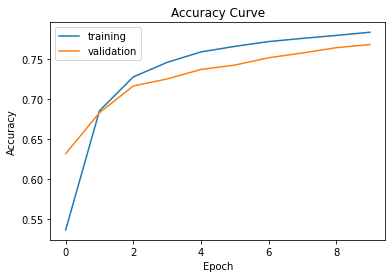

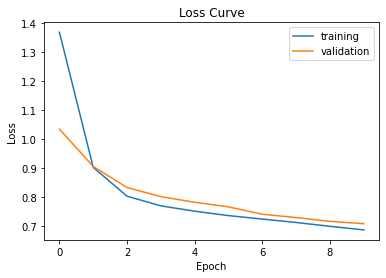

Best Validation Acccuracy: 0.7678


In [8]:
learning_rate = 1e-3
batch_size = 64
momentum = 9e-1
weight_decay = 5e-2
epochs = 10

training_loader = torch.utils.data.DataLoader(training_split, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(validation_split, batch_size=100, shuffle=False)

model = VGG(image_size=image_size, in_channels=in_channels).cuda()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum, weight_decay=weight_decay)

best = 0.0
best_cm = None
best_model = None
train_accuracy_history = []
train_loss_history = []
validation_accuracy_history = []
validation_loss_history = []
for epoch in range(epochs):
    train_acc, train_loss = train(epoch, training_loader, model, optimizer, criterion)
    train_accuracy_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    acc, cm, loss = validate(epoch, test_loader, model, criterion)
    validation_accuracy_history.append(acc)
    validation_loss_history.append(loss)
    
    print("Epoch {0} | Training accuracy: {1}% | Validation accuracy: {2}%".format(epoch, train_acc, acc))
    
    if acc > best:
        best = acc
        best_cm = cm
        best_model = copy.deepcopy(model)
        
training_curve, = plt.plot(train_accuracy_history, label='training')
validation_curve, = plt.plot(validation_accuracy_history, label='validation')
plt.title('Accuracy Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

training_curve, = plt.plot(train_loss_history, label='training')
validation_curve, = plt.plot(validation_loss_history, label='validation')
plt.title('Loss Curve')
plt.legend(handles=[training_curve, validation_curve])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Best Validation Acccuracy: {:.4f}'.format(best))

filename = f"{DIR}/checkpoints/{NAME}-vgg-training-with-fgsm-examples-defense-{fgsm_epsilon}.pth"
torch.save(best_model.state_dict(), filename)